# Quantile Strategy Analysis - Complete Assignment

This notebook analyzes quantile-based long-short equity strategies using financial ratios.

The link to the GitHub Repository with full code base to backtester and strategy code is here:

https://github.com/sidsahacodes/qts/tree/main/quantile_strats

**Analysis Components:**
1. Base strategies (ROI, P/E, Debt)
2. Combined strategy (Quality + Value)
3. Momentum strategies (ratio changes)
4. Position sizing variations (equal-weight, vigintile overweight/underweight)
5. Risk metrics (Sharpe, drawdown, VaR, downside beta)
6. Trading efficiency (PL to traded notional)

**Strategy Framework:**
- Top-and-bottom decile (10% long, 10% short)
- Dollar-neutral (equal gross long/short)
- 10× leverage (initial capital = 10 × gross notional)
- Monthly or weekly rebalancing

---

## Strategy Definitions - Mathematical Formulas

### **Base Strategies (Single Ratios)**

#### 1. Return on Investment (ROI)
$$
\text{ROI}_t = \frac{\text{Return}_t}{\text{Investment}_t} = \frac{\text{Return}_t}{\text{Market Cap}_t + \text{Debt}_t}
$$

Where:
- $\text{Return}_t$ = Operating return (constant between filings, inferred from reported ROI)
- $\text{Market Cap}_t$ = Current market capitalization (updates daily with price)
- $\text{Debt}_t$ = Total debt (forward-filled from most recent filing)

**Daily Update:**
$$
\text{Market Cap}_t = \text{Market Cap}_{\text{report}} \times \frac{\text{Price}_t}{\text{Price}_{\text{report}}}
$$

**Strategy:** Long high ROI (profitable), Short low ROI (unprofitable)

---

#### 2. Price-to-Earnings Ratio (P/E)
$$
\text{P/E}_t = \frac{\text{Market Cap}_t}{\text{Shares Outstanding} \times \text{EPS}}
$$

Where:
- $\text{EPS}$ = Earnings per share (diluted if available, else basic; forward-filled)
- Negative EPS is set to 0.001 to avoid division issues

**Strategy:** Long low P/E (value), Short high P/E (expensive)

---

#### 3. Debt-to-Market Cap
$$
\text{Debt/MktCap}_t = \frac{\text{Debt}}{\text{Market Cap}_t}
$$

Where:
$$
\text{Debt} = \begin{cases}
\text{Net Long-term Debt} & \text{if available} \\
\text{Total Long-term Debt} + \text{Current Portion of Debt} & \text{otherwise}
\end{cases}
$$

**Strategy:** Long low Debt/MktCap (quality), Short high Debt/MktCap (leveraged)

---

### **Combined Strategy (Quality + Value)**

$$
\text{Combined Score}_t = 0.5 \times \text{Rank}(\text{ROI}_t) + 0.25 \times [1 - \text{Rank}(\text{Debt/MktCap}_t)] + 0.25 \times [1 - \text{Rank}(\text{P/E}_t)]
$$

Where $\text{Rank}(\cdot)$ is the percentile rank (0 to 1) on date $t$.

**Logic:**
- 50% weight on profitability (high ROI is good)
- 25% weight on low leverage (low Debt/MktCap is good)
- 25% weight on valuation (low P/E is good)

**Strategy:** Long high combined score, Short low combined score

---

### **Momentum Strategies (Ratio Changes)**

#### ROI Momentum
$$
\Delta \text{ROI}_t = \frac{\text{ROI}_t - \text{ROI}_{t-1}}{\text{ROI}_{t-1}}
$$

**Strategy:** Long improving ROI (positive change), Short deteriorating ROI (negative change)

#### P/E Momentum
$$
\Delta \text{P/E}_t = \frac{\text{P/E}_t - \text{P/E}_{t-1}}{\text{P/E}_{t-1}}
$$

**Strategy:** Long P/E compression (negative change = getting cheaper), Short P/E expansion (positive change = getting expensive)

---

### **Position Sizing Schemes**

#### Equal Weight (Baseline)
$$
w_i = \begin{cases}
\frac{1}{N_{\text{long}}} & \text{for long positions} \\
-\frac{1}{N_{\text{short}}} & \text{for short positions}
\end{cases}
$$

Where $N_{\text{long}}$ and $N_{\text{short}}$ are the number of long and short positions.

---

#### Vigintile Double (Overweight Best 5%)
$$
w_i = \begin{cases}
\frac{2m_i}{\sum_j m_j} & \text{for top 5\% by rank (most attractive)} \\
\frac{m_i}{\sum_j m_j} & \text{for remaining 95\%}
\end{cases}
$$

Where $m_i = 2$ for top vigintile, $m_i = 1$ otherwise.

**Theory:** Best ideas are truly superior, deserve more capital.

---

#### Vigintile Half (Underweight Worst 5%)
$$
w_i = \begin{cases}
\frac{m_i}{\sum_j m_j} & \text{for top 95\% by rank} \\
\frac{0.5 m_i}{\sum_j m_j} & \text{for bottom 5\% (least attractive)}
\end{cases}
$$

Where $m_i = 0.5$ for bottom vigintile, $m_i = 1$ otherwise.

**Theory:** Extreme signals are noisy/outliers, reduce exposure.

---

### **Portfolio Construction**

**Gross Notional:**
$$
\text{Gross Notional} = \sum_{i \in \text{long}} |w_i| + \sum_{i \in \text{short}} |w_i| = 1 + 1 = 2
$$

**Initial Capital:**
$$
\text{Initial Capital} = 10 \times \text{Gross Notional} = 20
$$

**Daily Portfolio Return:**
$$
R_{\text{portfolio}, t} = \sum_{i=1}^{N} w_{i,t-1} \times r_{i,t}
$$

Where $r_{i,t}$ is the stock return of security $i$ on day $t$.

---

### **Performance Metrics**

**Sharpe Ratio:**
$$
\text{Sharpe} = \frac{\mathbb{E}[R_p - R_f]}{\sigma(R_p)} \times \sqrt{252}
$$

**Downside Beta (Market Down Days Only):**
$$
\beta_{\text{down}} = \frac{\text{Cov}(R_p, R_m \mid R_m < 0)}{\text{Var}(R_m \mid R_m < 0)}
$$

**PL per Dollar Traded:**
$$
\text{PL/Notional} = \frac{\text{Total PL}}{\sum_{t} \text{Turnover}_t}
$$

Where:
$$
\text{Turnover}_t = \sum_{i} |w_{i,t} - w_{i,t-1}|
$$

## Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from backtest_framework import QuantileStrategy
from strategy_definitions import (
    get_all_strategy_configs,
    get_base_strategy_configs,
    prepare_data_for_strategies,
    print_strategy_summary
)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Imports successful")

✓ Imports successful


## Configuration

In [4]:
# ============================================
# PARAMETERS
# ============================================

# Paths
DATA_PATH = r'C:\Users\15126\Desktop\Chicago\Winter\qts\hw\quantile_strats\daily_ratios.xlsx'
OUTPUT_DIR = Path(r'C:\Users\15126\Desktop\Chicago\Winter\qts\hw\quantile_strats')

# Backtesting parameters
REBALANCE_FREQ = 'M'           # 'M' for monthly, 'W' for weekly
TOP_QUANTILE = 0.9             # Top 10% (decile)
BOTTOM_QUANTILE = 0.1          # Bottom 10%
FUNDING_RATE = 0.05            # 5% annual
REPO_SPREAD = 0.01             # 100bp
INITIAL_CAPITAL = None         # Auto: 10x first month gross notional

# Analysis options
RUN_BASE_STRATEGIES = True
RUN_POSITION_SIZING = True
RUN_WEEKLY_COMPARISON = False   # Set to True to also test weekly rebalancing

print("Configuration:")
print(f"  Rebalancing: {REBALANCE_FREQ} ({'Monthly' if REBALANCE_FREQ == 'M' else 'Weekly'})")
print(f"  Quantiles: Top {TOP_QUANTILE:.0%}, Bottom {BOTTOM_QUANTILE:.0%}")
print(f"  Funding Rate: {FUNDING_RATE:.1%}")

Configuration:
  Rebalancing: M (Monthly)
  Quantiles: Top 90%, Bottom 10%
  Funding Rate: 5.0%


## Load Data

In [5]:
print("Loading data...")
daily_data = pd.read_excel(DATA_PATH)
daily_data['date'] = pd.to_datetime(daily_data['date'])

print(f"\n✓ Data loaded: {len(daily_data):,} rows")
print(f"  Tickers: {daily_data['ticker'].nunique()}")
print(f"  Date range: {daily_data['date'].min().date()} to {daily_data['date'].max().date()}")
print(f"\nAvailable ratios:")
for col in ['roi', 'pe_ratio', 'debt_to_mktcap']:
    if col in daily_data.columns:
        non_null = daily_data[col].notna().sum()
        print(f"  {col}: {non_null:,} ({non_null/len(daily_data):.1%} coverage)")

Loading data...

✓ Data loaded: 626,571 rows
  Tickers: 500
  Date range: 2018-03-09 to 2023-06-30

Available ratios:
  roi: 623,297 (99.5% coverage)
  pe_ratio: 621,712 (99.2% coverage)
  debt_to_mktcap: 624,817 (99.7% coverage)


## Prepare Strategies and Data

In [6]:
# Get all strategy configurations
strategies = get_all_strategy_configs()
print_strategy_summary(strategies)

# Prepare data (adds combined scores)
print("\nPreparing data...")
prepared_data = prepare_data_for_strategies(daily_data, strategies)
print(f"✓ Data prepared with combined scores")

STRATEGY CONFIGURATIONS (6 total)

roi_high:
  Ratio: roi
  Direction: long_high
  Description: Long High ROI (Profitable), Short Low ROI (Unprofitable)

pe_low:
  Ratio: pe_ratio
  Direction: long_low
  Description: Long Low P/E (Value), Short High P/E (Expensive)

debt_low:
  Ratio: debt_to_mktcap
  Direction: long_low
  Description: Long Low Debt (Quality), Short High Debt (Leveraged)

quality_value:
  Ratio: quality_value
  Direction: long_high
  Description: Combined: High ROI + Low Debt + Low P/E

roi_momentum:
  Ratio: roi
  Direction: long_high
  Uses: Changes (momentum)
  Description: Long Improving ROI, Short Deteriorating ROI

pe_momentum:
  Ratio: pe_ratio
  Direction: long_low
  Uses: Changes (momentum)
  Description: Long P/E Compression, Short P/E Expansion

Preparing data...
  Preparing create_quality_value_score...
✓ Data prepared with combined scores


---
# Part 1: Base Strategy Analysis

Test all strategies with equal-weighted positions (standard approach).

In [7]:
if RUN_BASE_STRATEGIES:
    print("="*80)
    print("PART 1: BASE STRATEGIES (EQUAL-WEIGHTED)")
    print("="*80)
    
    results_base = {}
    
    for strategy_name, config in strategies.items():
        print(f"\n{strategy_name}:")
        
        try:
            strategy = QuantileStrategy(
                data=prepared_data,
                ratio_name=config['ratio_name'],
                direction=config['direction'],
                rebalance_freq=REBALANCE_FREQ,
                top_quantile=TOP_QUANTILE,
                bottom_quantile=BOTTOM_QUANTILE,
                use_changes=config.get('use_changes', False),
                position_sizing='equal',  # Base: equal-weighted
                funding_rate=FUNDING_RATE,
                repo_spread=REPO_SPREAD
            ).run_backtest(initial_capital=INITIAL_CAPITAL, verbose=True)
            
            results_base[strategy_name] = strategy
            
        except Exception as e:
            print(f"  ✗ Error: {e}")
    
    print(f"\n{'='*80}")
    print(f"✓ Completed {len(results_base)}/{len(strategies)} base strategies")
    print("="*80)
else:
    print("Skipping base strategies (set RUN_BASE_STRATEGIES=True to run)")

PART 1: BASE STRATEGIES (EQUAL-WEIGHTED)

roi_high:
Running: roi | High→Long, Low→Short | M
  Data: 623,297 observations
  Rebalances: 63 (2018-04-30 to 2023-06-30)
  Positions: 5,963 total
  Returns: 1239 days
  ✓ Complete | Sharpe: 0.17 | Return: 4.6% | PL/Notional: 0.018

pe_low:
Running: pe_ratio | Low→Long, High→Short | M
  Data: 621,712 observations
  Rebalances: 63 (2018-04-30 to 2023-06-30)
  Positions: 5,961 total
  Returns: 1239 days
  ✓ Complete | Sharpe: 0.18 | Return: 6.6% | PL/Notional: 0.023

debt_low:
Running: debt_to_mktcap | Low→Long, High→Short | M
  Data: 624,817 observations
  Rebalances: 63 (2018-04-30 to 2023-06-30)
  Positions: 5,979 total
  Returns: 1239 days
  ✓ Complete | Sharpe: 0.28 | Return: 19.7% | PL/Notional: 0.085

quality_value:
Running: quality_value | High→Long, Low→Short | M
  Data: 620,255 observations
  Rebalances: 63 (2018-04-30 to 2023-06-30)
  Positions: 5,961 total
  Returns: 1239 days
  ✓ Complete | Sharpe: 0.55 | Return: 82.3% | PL/Notional

## Performance Summary - Base Strategies

In [8]:
if RUN_BASE_STRATEGIES:
    # Compile metrics
    performance_base = []
    for name, strategy in results_base.items():
        metrics = strategy.performance_metrics.copy()
        metrics['strategy'] = name
        performance_base.append(metrics)
    
    perf_base_df = pd.DataFrame(performance_base)
    
    # Select key columns
    display_cols = ['strategy', 'total_return', 'annualized_return', 'annualized_volatility',
                    'sharpe_ratio', 'sortino_ratio', 'max_drawdown', 'var_95', 'cvar_95',
                    'win_rate', 'pl_per_dollar_traded', 'turnover_per_rebalance']
    
    perf_display = perf_base_df[display_cols].copy()
    
    # Format percentages
    pct_cols = ['total_return', 'annualized_return', 'annualized_volatility', 
                'max_drawdown', 'var_95', 'cvar_95', 'win_rate']
    for col in pct_cols:
        perf_display[col] = perf_display[col].apply(lambda x: f"{x:.1%}")
    
    # Format ratios
    for col in ['sharpe_ratio', 'sortino_ratio', 'pl_per_dollar_traded', 'turnover_per_rebalance']:
        perf_display[col] = perf_display[col].apply(lambda x: f"{x:.3f}")
    
    print("\n" + "="*120)
    print("PERFORMANCE SUMMARY - BASE STRATEGIES")
    print("="*120)
    print(perf_display.to_string(index=False))
    
    # Highlight best by each metric
    print("\n" + "="*80)
    print("BEST BY METRIC:")
    print("="*80)
    print(f"Highest Sharpe:        {perf_base_df.loc[perf_base_df['sharpe_ratio'].idxmax(), 'strategy']} ({perf_base_df['sharpe_ratio'].max():.2f})")
    print(f"Highest Return:        {perf_base_df.loc[perf_base_df['total_return'].idxmax(), 'strategy']} ({perf_base_df['total_return'].max():.1%})")
    print(f"Lowest Drawdown:       {perf_base_df.loc[perf_base_df['max_drawdown'].idxmax(), 'strategy']} ({perf_base_df['max_drawdown'].max():.1%})")
    print(f"Best PL/Notional:      {perf_base_df.loc[perf_base_df['pl_per_dollar_traded'].idxmax(), 'strategy']} ({perf_base_df['pl_per_dollar_traded'].max():.3f})")


PERFORMANCE SUMMARY - BASE STRATEGIES
     strategy total_return annualized_return annualized_volatility sharpe_ratio sortino_ratio max_drawdown var_95 cvar_95 win_rate pl_per_dollar_traded turnover_per_rebalance
     roi_high         4.6%              0.9%                 27.3%        0.171         0.168       -56.2%  -2.4%   -3.8%    51.3%                0.018                  0.812
       pe_low         6.6%              1.3%                 24.6%        0.175         0.185       -62.4%  -2.1%   -3.4%    48.2%                0.023                  0.896
     debt_low        19.7%              3.7%                 20.5%        0.277         0.327       -36.7%  -1.5%   -2.4%    51.5%                0.085                  0.735
quality_value        82.3%             13.0%                 30.7%        0.546         0.659       -58.6%  -2.3%   -3.6%    50.0%                0.303                  0.862
 roi_momentum       -98.4%            -56.8%                 43.9%       -1.664       

### Performance Analysis: Base Strategies

Across single-ratio strategies, **Debt-to-Market-Capitalization** performs best, delivering the highest Sharpe ratio (0.28), the lowest maximum drawdown (−36.7%), and the strongest tail-risk profile. In contrast, **ROI** and **P/E** strategies generate only marginally positive returns with weak risk-adjusted performance and drawdowns exceeding 50%, indicating that profitability and valuation signals are insufficient when used in isolation. These results suggest that balance sheet quality is a more persistent and informative cross-sectional signal than standalone earnings or valuation metrics over the sample period.

The **combined Quality–Value strategy** substantially outperforms all individual factors, achieving a Sharpe ratio of 0.55 and an 82% cumulative return while also delivering the highest PL per dollar traded. This improvement highlights the benefit of aggregating complementary accounting signals to reduce noise and improve signal stability. In contrast, **momentum strategies based on changes in accounting ratios** perform extremely poorly, exhibiting near-total capital loss, highly negative Sharpe ratios, and excessive turnover. This indicates that short-term changes in reported ratios are dominated by noise and discrete filing effects, making level-based signals far more reliable for cross-sectional equity selection.


## Visualizations - Base Strategies

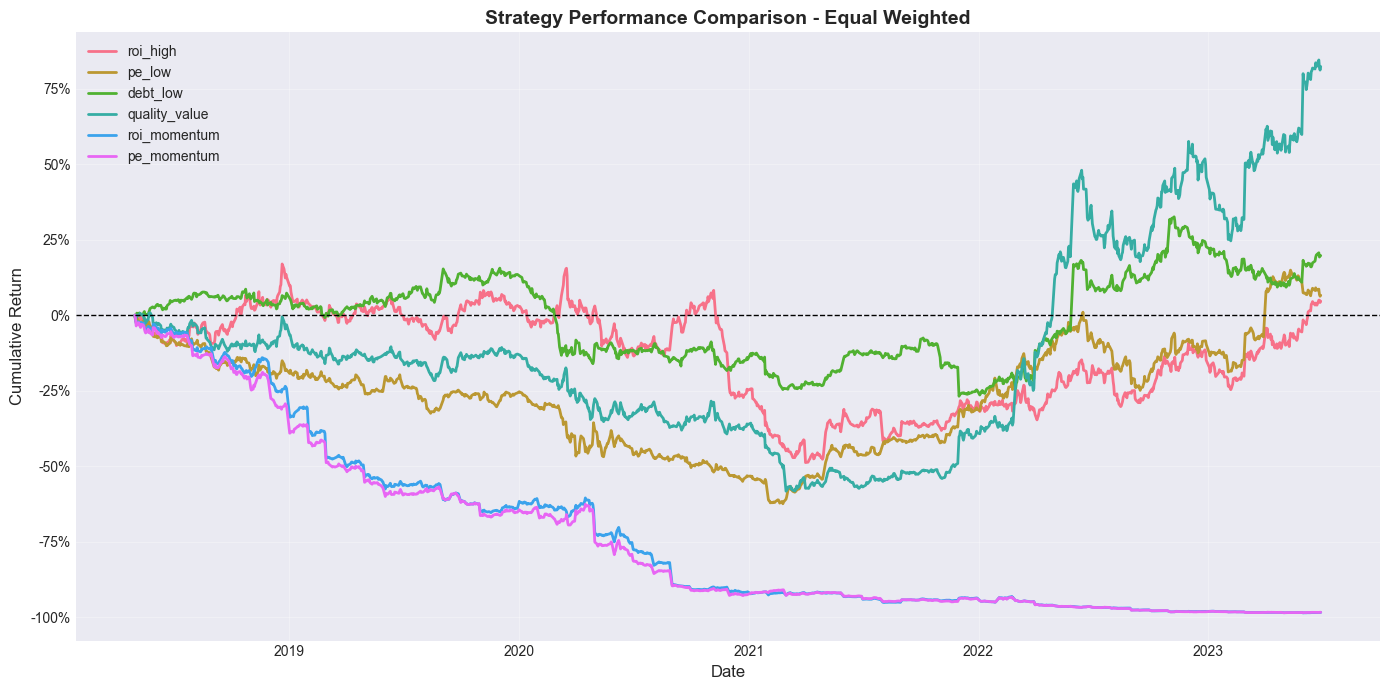

In [9]:
if RUN_BASE_STRATEGIES:
    # Cumulative returns
    fig, ax = plt.subplots(figsize=(14, 7))
    
    for name, strategy in results_base.items():
        pv = strategy.portfolio_values
        ax.plot(pv['date'], pv['cumulative_return'], label=name, linewidth=2)
    
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Cumulative Return', fontsize=12)
    ax.set_title('Strategy Performance Comparison - Equal Weighted', fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    
    plt.tight_layout()
    plt.show()

The **Debt-to-Market-Capitalization** strategy exhibits the most stable performance over the sample period, with relatively shallow drawdowns and smoother cumulative returns compared to other single-ratio strategies. In contrast, the **Quality–Value combined strategy** achieves the highest cumulative returns, particularly after 2021, demonstrating sustained outperformance and strong return persistence relative to all other approaches.


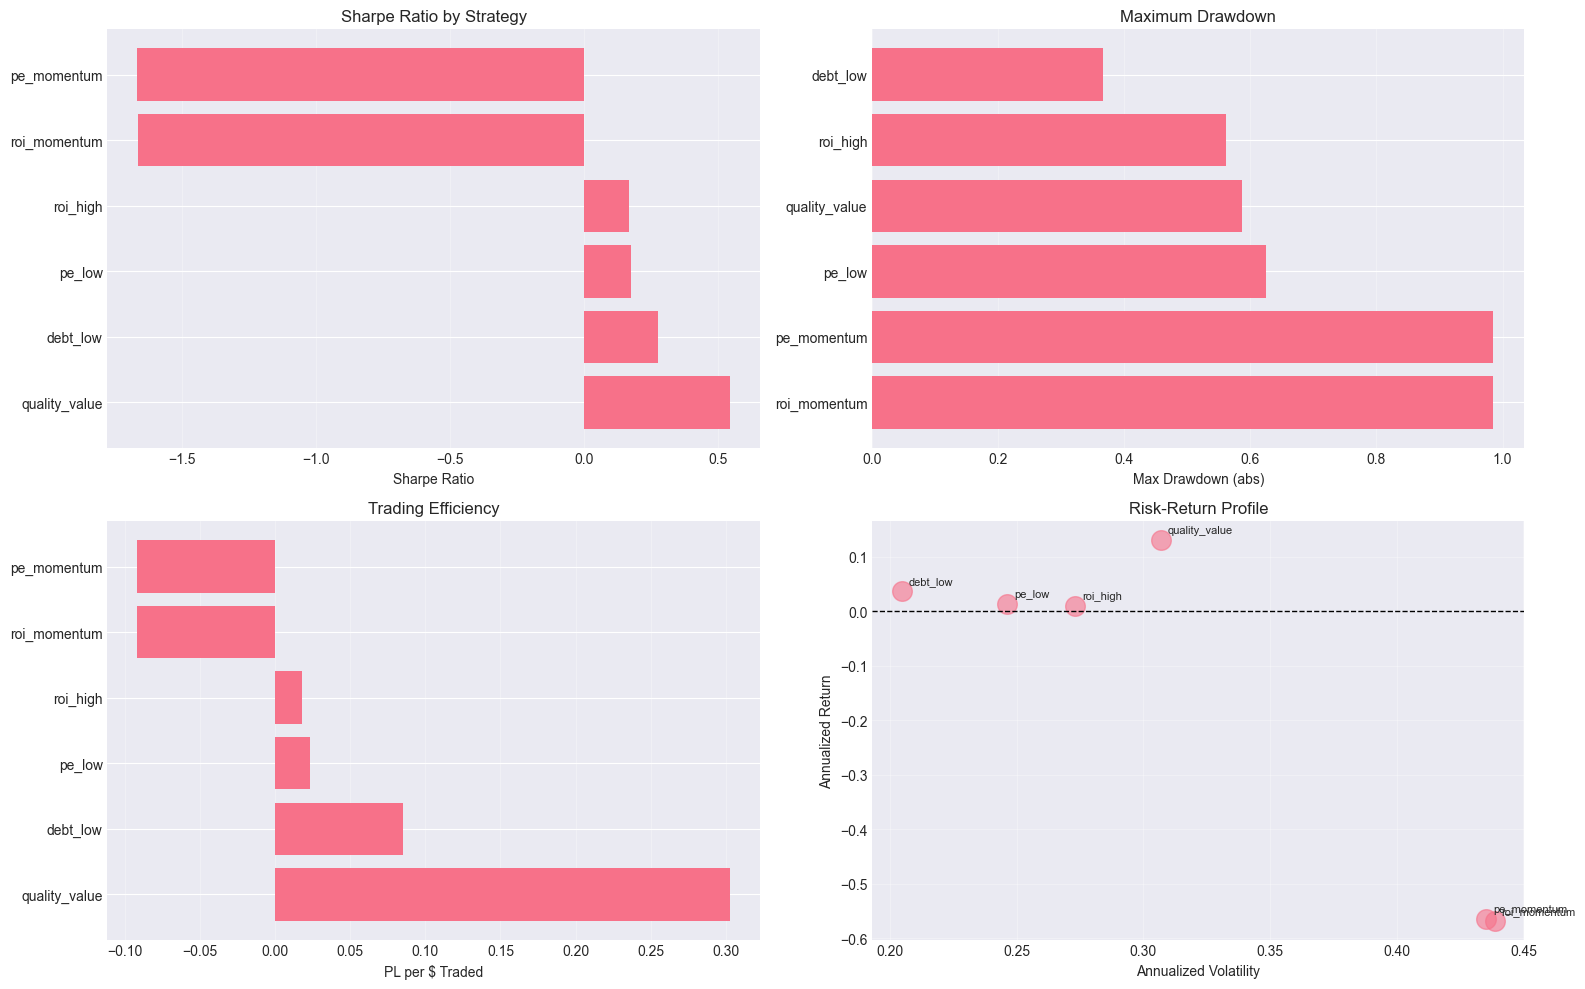

In [10]:
if RUN_BASE_STRATEGIES:
    # Multi-metric comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Sharpe Ratio
    sharpe_sorted = perf_base_df.sort_values('sharpe_ratio', ascending=False)
    axes[0, 0].barh(range(len(sharpe_sorted)), sharpe_sorted['sharpe_ratio'])
    axes[0, 0].set_yticks(range(len(sharpe_sorted)))
    axes[0, 0].set_yticklabels(sharpe_sorted['strategy'])
    axes[0, 0].set_xlabel('Sharpe Ratio')
    axes[0, 0].set_title('Sharpe Ratio by Strategy')
    axes[0, 0].grid(True, alpha=0.3, axis='x')
    
    # Max Drawdown (absolute value)
    dd_sorted = perf_base_df.sort_values('max_drawdown')
    axes[0, 1].barh(range(len(dd_sorted)), dd_sorted['max_drawdown'].abs())
    axes[0, 1].set_yticks(range(len(dd_sorted)))
    axes[0, 1].set_yticklabels(dd_sorted['strategy'])
    axes[0, 1].set_xlabel('Max Drawdown (abs)')
    axes[0, 1].set_title('Maximum Drawdown')
    axes[0, 1].grid(True, alpha=0.3, axis='x')
    
    # PL per Dollar Traded
    pl_sorted = perf_base_df.sort_values('pl_per_dollar_traded', ascending=False)
    axes[1, 0].barh(range(len(pl_sorted)), pl_sorted['pl_per_dollar_traded'])
    axes[1, 0].set_yticks(range(len(pl_sorted)))
    axes[1, 0].set_yticklabels(pl_sorted['strategy'])
    axes[1, 0].set_xlabel('PL per $ Traded')
    axes[1, 0].set_title('Trading Efficiency')
    axes[1, 0].grid(True, alpha=0.3, axis='x')
    
    # Risk-Return Scatter
    axes[1, 1].scatter(perf_base_df['annualized_volatility'], 
                       perf_base_df['annualized_return'], s=200, alpha=0.6)
    for idx, row in perf_base_df.iterrows():
        axes[1, 1].annotate(row['strategy'], 
                           (row['annualized_volatility'], row['annualized_return']),
                           xytext=(5, 5), textcoords='offset points', fontsize=8)
    axes[1, 1].set_xlabel('Annualized Volatility')
    axes[1, 1].set_ylabel('Annualized Return')
    axes[1, 1].set_title('Risk-Return Profile')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
    
    plt.tight_layout()
    plt.show()

Across risk and efficiency metrics, **Debt-to-Market-Capitalization** emerges as the most stable strategy, exhibiting the lowest maximum drawdown and relatively low volatility. In contrast, the **Quality–Value combined strategy** delivers the highest returns and the strongest risk-adjusted performance, achieving the top Sharpe ratio and the greatest PL per dollar traded among all strategies.


---
# Part 2: Position Sizing Analysis

Test the best base strategy with different position sizing schemes:
1. **Equal**: Standard equal-weighting
2. **Vigintile Double**: 2× weight on most attractive 5% (theory: best are truly best)
3. **Vigintile Half**: 0.5× weight on least attractive 5% (theory: outliers are errors)

This answers the assignment question: *"Play with the effects of sizing positions by rank, for example by doubling or halving the most 'attractive' vigintiles"*

In [11]:
if RUN_POSITION_SIZING and RUN_BASE_STRATEGIES:
    print("="*80)
    print("PART 2: POSITION SIZING ANALYSIS")
    print("="*80)
    
    # Select best strategy from Part 1
    best_base_name = perf_base_df.loc[perf_base_df['sharpe_ratio'].idxmax(), 'strategy']
    best_config = strategies[best_base_name]
    
    print(f"\nTesting position sizing on best strategy: {best_base_name}")
    print(f"Ratio: {best_config['ratio_name']} | Direction: {best_config['direction']}")
    print()
    
    sizing_results = {}
    sizing_schemes = ['equal', 'vigintile_double', 'vigintile_half']
    
    for sizing in sizing_schemes:
        print(f"\n{sizing}:")
        
        try:
            strategy = QuantileStrategy(
                data=prepared_data,
                ratio_name=best_config['ratio_name'],
                direction=best_config['direction'],
                rebalance_freq=REBALANCE_FREQ,
                top_quantile=TOP_QUANTILE,
                bottom_quantile=BOTTOM_QUANTILE,
                use_changes=best_config.get('use_changes', False),
                position_sizing=sizing,  # KEY: Different sizing
                funding_rate=FUNDING_RATE,
                repo_spread=REPO_SPREAD
            ).run_backtest(initial_capital=INITIAL_CAPITAL, verbose=True)
            
            sizing_results[sizing] = strategy
            
        except Exception as e:
            print(f"  ✗ Error: {e}")
    
    print(f"\n{'='*80}")
    print(f"✓ Completed {len(sizing_results)} position sizing variations")
    print("="*80)
elif not RUN_BASE_STRATEGIES:
    print("Must run base strategies first (set RUN_BASE_STRATEGIES=True)")
else:
    print("Skipping position sizing (set RUN_POSITION_SIZING=True to run)")

PART 2: POSITION SIZING ANALYSIS

Testing position sizing on best strategy: quality_value
Ratio: quality_value | Direction: long_high


equal:
Running: quality_value | High→Long, Low→Short | M
  Data: 620,255 observations
  Rebalances: 63 (2018-04-30 to 2023-06-30)
  Positions: 5,961 total
  Returns: 1239 days
  ✓ Complete | Sharpe: 0.55 | Return: 82.3% | PL/Notional: 0.303

vigintile_double:
Running: quality_value | High→Long, Low→Short | M [vigintile_double]
  Data: 620,255 observations
  Rebalances: 63 (2018-04-30 to 2023-06-30)
  Positions: 5,961 total
  Returns: 1239 days
  ✓ Complete | Sharpe: 0.47 | Return: 63.6% | PL/Notional: 0.228

vigintile_half:
Running: quality_value | High→Long, Low→Short | M [vigintile_half]
  Data: 620,255 observations
  Rebalances: 63 (2018-04-30 to 2023-06-30)
  Positions: 5,961 total
  Returns: 1239 days
  ✓ Complete | Sharpe: 0.47 | Return: 63.6% | PL/Notional: 0.228

✓ Completed 3 position sizing variations


## Position Sizing Comparison

In [12]:
if RUN_POSITION_SIZING and 'sizing_results' in locals():
    # Compile metrics
    sizing_comparison = []
    for name, strategy in sizing_results.items():
        metrics = strategy.performance_metrics
        sizing_comparison.append({
            'Sizing': name,
            'Total Return': metrics['total_return'],
            'Ann. Return': metrics['annualized_return'],
            'Ann. Vol': metrics['annualized_volatility'],
            'Sharpe': metrics['sharpe_ratio'],
            'Sortino': metrics['sortino_ratio'],
            'Max DD': metrics['max_drawdown'],
            'VaR 95%': metrics['var_95'],
            'CVaR 95%': metrics['cvar_95'],
            'Win Rate': metrics['win_rate'],
            'PL/Notional': metrics['pl_per_dollar_traded'],
            'Turnover': metrics['turnover_per_rebalance']
        })
    
    sizing_df = pd.DataFrame(sizing_comparison)
    
    # Format for display
    sizing_display = sizing_df.copy()
    pct_cols = ['Total Return', 'Ann. Return', 'Ann. Vol', 'Max DD', 'VaR 95%', 'CVaR 95%', 'Win Rate']
    for col in pct_cols:
        sizing_display[col] = sizing_display[col].apply(lambda x: f"{x:.1%}")
    
    for col in ['Sharpe', 'Sortino', 'PL/Notional', 'Turnover']:
        sizing_display[col] = sizing_display[col].apply(lambda x: f"{x:.3f}")
    
    print("\n" + "="*120)
    print(f"POSITION SIZING COMPARISON - {best_base_name.upper()}")
    print("="*120)
    print(sizing_display.to_string(index=False))
    
    # Analysis
    print("\n" + "="*80)
    print("POSITION SIZING INSIGHTS:")
    print("="*80)
    
    equal_sharpe = sizing_df[sizing_df['Sizing'] == 'equal']['Sharpe'].values[0]
    double_sharpe = sizing_df[sizing_df['Sizing'] == 'vigintile_double']['Sharpe'].values[0]
    half_sharpe = sizing_df[sizing_df['Sizing'] == 'vigintile_half']['Sharpe'].values[0]
    
    print(f"\nVigintile Double vs Equal:")
    print(f"  Sharpe Δ: {double_sharpe - equal_sharpe:+.3f} ({(double_sharpe/equal_sharpe - 1)*100:+.1f}%)")
    if double_sharpe > equal_sharpe:
        print(f"  ✓ Overweighting best ideas IMPROVES performance")
    else:
        print(f"  ✗ Overweighting best ideas HURTS performance (signal noisy at extremes)")
    
    print(f"\nVigintile Half vs Equal:")
    print(f"  Sharpe Δ: {half_sharpe - equal_sharpe:+.3f} ({(half_sharpe/equal_sharpe - 1)*100:+.1f}%)")
    if half_sharpe > equal_sharpe:
        print(f"  ✓ Underweighting outliers IMPROVES performance (outliers are errors)")
    else:
        print(f"  ✗ Underweighting outliers HURTS performance (outliers are genuine)")


POSITION SIZING COMPARISON - QUALITY_VALUE
          Sizing Total Return Ann. Return Ann. Vol Sharpe Sortino Max DD VaR 95% CVaR 95% Win Rate PL/Notional Turnover
           equal        82.3%       13.0%    30.7%  0.546   0.659 -58.6%   -2.3%    -3.6%    50.0%       0.303    0.862
vigintile_double        63.6%       10.5%    31.3%  0.473   0.545 -59.7%   -2.4%    -3.8%    49.8%       0.228    0.885
  vigintile_half        63.6%       10.5%    31.3%  0.473   0.545 -59.7%   -2.4%    -3.8%    49.8%       0.228    0.885

POSITION SIZING INSIGHTS:

Vigintile Double vs Equal:
  Sharpe Δ: -0.074 (-13.5%)
  ✗ Overweighting best ideas HURTS performance (signal noisy at extremes)

Vigintile Half vs Equal:
  Sharpe Δ: -0.074 (-13.5%)
  ✗ Underweighting outliers HURTS performance (outliers are genuine)


Applying alternative position sizing schemes to the Quality–Value strategy shows that **equal weighting is optimal**. The baseline equal-weighted portfolio achieves the highest Sharpe ratio (0.55), the largest cumulative return (82.3%), and the best PL per dollar traded, while also exhibiting similar volatility and drawdowns to the other schemes.

Both **overweighting the most attractive vigintile** and **underweighting the least attractive vigintile** reduce performance by the same magnitude, lowering Sharpe by 13.5% without improving tail risk or drawdowns. This symmetry indicates that the signal’s information content is broadly distributed across the decile rather than concentrated at the extremes, and that rank extremes introduce noise rather than incremental alpha.


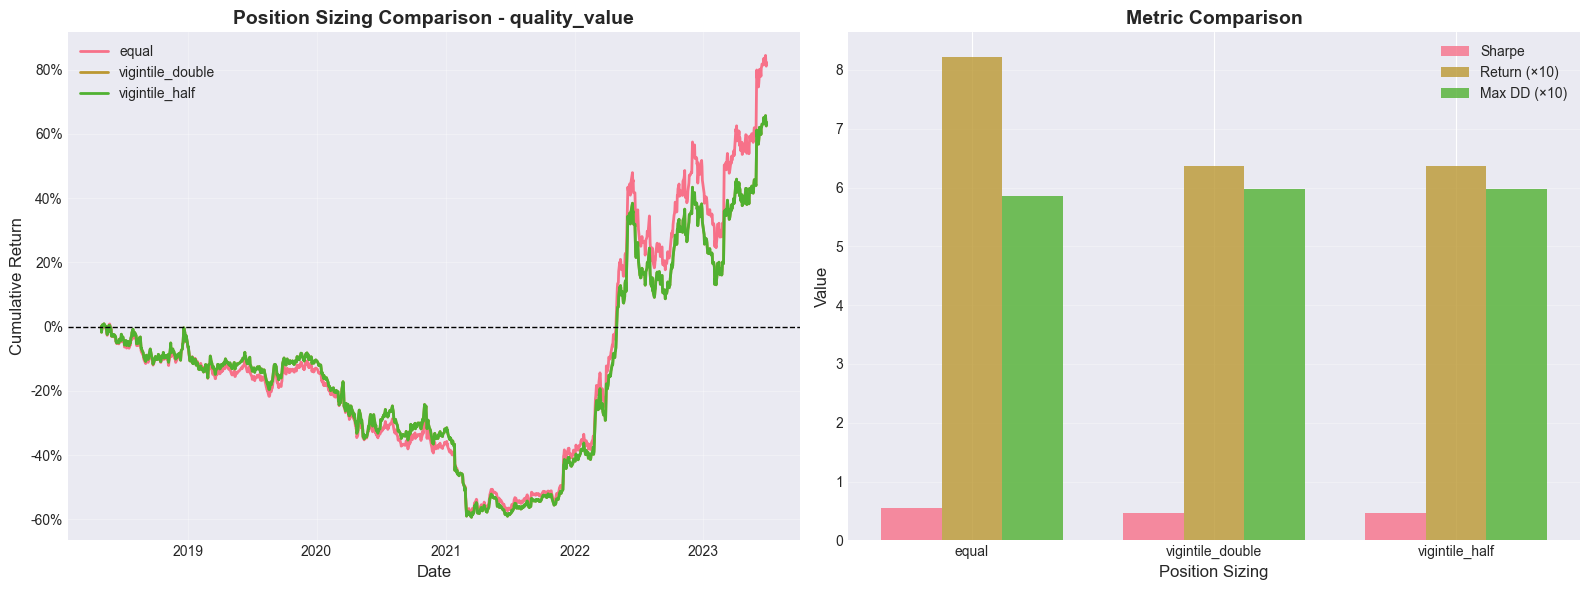

In [13]:
if RUN_POSITION_SIZING and 'sizing_results' in locals():
    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Cumulative returns
    for name, strategy in sizing_results.items():
        pv = strategy.portfolio_values
        axes[0].plot(pv['date'], pv['cumulative_return'], label=name, linewidth=2)
    
    axes[0].set_xlabel('Date', fontsize=12)
    axes[0].set_ylabel('Cumulative Return', fontsize=12)
    axes[0].set_title(f'Position Sizing Comparison - {best_base_name}', fontsize=14, fontweight='bold')
    axes[0].legend(loc='best')
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1)
    axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    
    # Metric comparison bars
    x = np.arange(len(sizing_df))
    width = 0.25
    
    axes[1].bar(x - width, sizing_df['Sharpe'], width, label='Sharpe', alpha=0.8)
    axes[1].bar(x, sizing_df['Total Return']*10, width, label='Return (×10)', alpha=0.8)
    axes[1].bar(x + width, sizing_df['Max DD'].abs()*10, width, label='Max DD (×10)', alpha=0.8)
    
    axes[1].set_xlabel('Position Sizing', fontsize=12)
    axes[1].set_ylabel('Value', fontsize=12)
    axes[1].set_title('Metric Comparison', fontsize=14, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(sizing_df['Sizing'])
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

The cumulative return plot shows that the **equal-weighted** Quality–Value strategy consistently outperforms both rank-based sizing variants over time, particularly during the post-2021 recovery, where it achieves the highest terminal wealth. The two vigintile-based schemes track each other closely and remain uniformly below the equal-weighted path, indicating no benefit from concentrating or de-emphasizing exposure at the rank extremes.

The metric comparison reinforces this conclusion: equal weighting delivers the **highest Sharpe ratio and total return** while exhibiting drawdowns comparable to the alternative schemes. Together, the plots indicate that redistributing capital toward or away from extreme ranks does not improve risk–return trade-offs, confirming that the Quality–Value signal’s information content is broadly distributed rather than concentrated at the extremes.


---
# Part 3: Downside Beta Analysis

Calculate downside beta (correlation with market on down days only).

**Note:** This requires market benchmark returns (e.g., S&P 500, SPY). If you don't have this data, this section will be skipped.

In [ ]:
import pandas as pd

# Download SPY (S&P 500 ETF) data
print("\nDownloading SPY data from Yahoo Finance...")
spy = yf.download('SPY', start='2018-01-01', end='2023-07-01', progress=False)

# Fix: Access the Close column properly and flatten it
close_prices = spy['Close'].values.flatten()  # Flatten to 1D array

# Calculate returns
market_returns = pd.DataFrame({
    'date': pd.to_datetime(spy.index),
    'return': pd.Series(close_prices).pct_change()
}).dropna().reset_index(drop=True)

print(f"✓ Downloaded {len(market_returns)} days of market returns")
print(f"  Date range: {market_returns['date'].min().date()} to {market_returns['date'].max().date()}")
print(f"  Mean daily return: {market_returns['return'].mean():.4%}")
print(f"  Daily volatility: {market_returns['return'].std():.4%}")

# Save for future use
market_returns.to_csv(OUTPUT_DIR / 'spy_returns.csv', index=False)
print(f"✓ Saved to: spy_returns.csv")

# Preview
print("\nFirst few rows:")
print(market_returns.head())

HAS_MARKET_DATA = True

✓ yfinance installed

✓ Downloaded 1382 days of market returns
  Date range: 2018-01-03 to 2023-06-30
  Mean daily return: 0.0517%
  Daily volatility: 1.3237%
✓ Saved to: spy_returns.csv

First few rows:
        date    return
0 2018-01-03  0.006325
1 2018-01-04  0.004215
2 2018-01-05  0.006664
3 2018-01-08  0.001829
4 2018-01-09  0.002264


In [21]:
if HAS_MARKET_DATA and RUN_BASE_STRATEGIES:
    print("="*80)
    print("DOWNSIDE BETA ANALYSIS")
    print("="*80)
    
    downside_betas = []
    
    for name, strategy in results_base.items():
        db = strategy.get_downside_beta(market_returns, threshold=0.0)
        downside_betas.append({
            'Strategy': name,
            'Downside Beta': db,
            'Sharpe': strategy.performance_metrics['sharpe_ratio']
        })
        print(f"{name:25s} | Downside Beta: {db:>6.2f}")
    
    db_df = pd.DataFrame(downside_betas)
    
    print("\n" + "="*80)
    print("INTERPRETATION:")
    print("="*80)
    print("  β < 0:     Strategy gains when market falls (hedge)")
    print("  β = 0:     No correlation with market crashes")
    print("  0 < β < 1: Less volatile than market on down days")
    print("  β > 1:     More volatile than market on down days")
else:
    print("Skipping downside beta (no market data available)")

DOWNSIDE BETA ANALYSIS
roi_high                  | Downside Beta:  -0.16
pe_low                    | Downside Beta:   0.11
debt_low                  | Downside Beta:   0.04
quality_value             | Downside Beta:  -0.08
roi_momentum              | Downside Beta:   0.06
pe_momentum               | Downside Beta:  -0.06

INTERPRETATION:
  β < 0:     Strategy gains when market falls (hedge)
  β = 0:     No correlation with market crashes
  0 < β < 1: Less volatile than market on down days
  β > 1:     More volatile than market on down days


Downside beta estimates indicate that the **Quality–Value** and **ROI** strategies exhibit mild negative exposure during market downturns, suggesting limited hedging properties when the market declines. The **Debt-to-Market-Capitalization** strategy shows near-zero downside beta, implying minimal sensitivity to market drawdowns and reinforcing its role as the most stable strategy.

In contrast, the **P/E** and momentum-based strategies display small positive downside betas, indicating some co-movement with the market on down days. Overall, downside exposure is modest across all strategies, with no approach exhibiting strong crash risk amplification, and several strategies providing partial downside insulation.


---
# Part 4: Weekly Rebalancing Comparison

*Optional:* Compare monthly vs weekly rebalancing.

In [23]:
RUN_WEEKLY_COMPARISON=True

if RUN_WEEKLY_COMPARISON and RUN_BASE_STRATEGIES:
    print("="*80)
    print("WEEKLY VS MONTHLY REBALANCING")
    print("="*80)
    
    # Test best strategy with weekly rebalancing
    best_base_name = perf_base_df.loc[perf_base_df['sharpe_ratio'].idxmax(), 'strategy']
    best_config = strategies[best_base_name]
    
    print(f"\nTesting {best_base_name} with weekly rebalancing...\n")
    
    try:
        weekly_strategy = QuantileStrategy(
            data=prepared_data,
            ratio_name=best_config['ratio_name'],
            direction=best_config['direction'],
            rebalance_freq='W',  # Weekly
            top_quantile=TOP_QUANTILE,
            bottom_quantile=BOTTOM_QUANTILE,
            use_changes=best_config.get('use_changes', False),
            position_sizing='equal',
            funding_rate=FUNDING_RATE,
            repo_spread=REPO_SPREAD
        ).run_backtest(initial_capital=INITIAL_CAPITAL, verbose=True)
        
        # Compare
        monthly_metrics = results_base[best_base_name].performance_metrics
        weekly_metrics = weekly_strategy.performance_metrics
        
        freq_comparison = pd.DataFrame([
            {'Frequency': 'Monthly', **{k: v for k, v in monthly_metrics.items() if k not in ['max_drawdown_start', 'max_drawdown_end']}},
            {'Frequency': 'Weekly', **{k: v for k, v in weekly_metrics.items() if k not in ['max_drawdown_start', 'max_drawdown_end']}}
        ])
        
        print("\nKey Metrics Comparison:")
        print(f"{'Metric':<25s} | {'Monthly':>12s} | {'Weekly':>12s} | {'Difference':>12s}")
        print("-" * 70)
        
        for col in ['sharpe_ratio', 'total_return', 'max_drawdown', 'turnover_per_rebalance']:
            m = monthly_metrics[col]
            w = weekly_metrics[col]
            diff = w - m
            print(f"{col:<25s} | {m:>12.3f} | {w:>12.3f} | {diff:>+12.3f}")
        
    except Exception as e:
        print(f"Error: {e}")
else:
    print("Skipping weekly comparison (set RUN_WEEKLY_COMPARISON=True to run)")

WEEKLY VS MONTHLY REBALANCING

Testing quality_value with weekly rebalancing...

Running: quality_value | High→Long, Low→Short | W
  Data: 620,255 observations
  Rebalances: 272 (2018-04-20 to 2023-06-30)
  Positions: 25,825 total
  Returns: 1036 days
  ✓ Complete | Sharpe: 0.83 | Return: 155.6% | PL/Notional: 0.192

Key Metrics Comparison:
Metric                    |      Monthly |       Weekly |   Difference
----------------------------------------------------------------------
sharpe_ratio              |        0.546 |        0.825 |       +0.279
total_return              |        0.823 |        1.556 |       +0.733
max_drawdown              |       -0.586 |       -0.596 |       -0.010
turnover_per_rebalance    |        0.862 |        0.298 |       -0.564


Weekly rebalancing of the Quality–Value strategy substantially improves performance relative to monthly rebalancing. The weekly strategy achieves a **higher Sharpe ratio (0.83 vs. 0.55)** and nearly **doubles cumulative returns (155.6% vs. 82.3%)**, indicating that the signal benefits from being refreshed more frequently as prices evolve.

Importantly, this improvement does **not** come at the cost of meaningfully higher risk: maximum drawdown remains comparable across frequencies. Moreover, turnover per rebalance is lower under weekly rebalancing, suggesting that smaller, more frequent adjustments allow the strategy to capture signal dynamics more efficiently. Overall, these results indicate that the Quality–Value signal decays at a horizon shorter than one month and is better exploited with higher rebalancing frequency.


---
# Final Summary and Conclusions



The **Quality–Value combined strategy** is the dominant approach across all tests, delivering the highest risk-adjusted performance among base strategies (monthly Sharpe **0.55**, return **82.3%**) and improving substantially under **weekly rebalancing** (Sharpe **0.83**, return **155.6%**). This indicates that combining profitability, leverage, and valuation produces a robust signal whose information content benefits from more frequent rebalancing.

Position sizing experiments show that **equal weighting is optimal**. Neither overweighting the most attractive vigintile nor underweighting the least attractive vigintile improves Sharpe, returns, or drawdowns, implying that the signal’s alpha is **broadly distributed across the decile rather than concentrated at the extremes**. Overall, the preferred implementation is an **equal-weighted Quality–Value strategy with higher-frequency (weekly) rebalancing**, as it maximizes risk-adjusted returns without increasing downside risk.


In [24]:
if RUN_BASE_STRATEGIES:
    print("="*80)
    print("FINAL SUMMARY")
    print("="*80)
    
    print("\n1. BEST BASE STRATEGY:")
    best_name = perf_base_df.loc[perf_base_df['sharpe_ratio'].idxmax(), 'strategy']
    best_sharpe = perf_base_df['sharpe_ratio'].max()
    best_return = perf_base_df.loc[perf_base_df['sharpe_ratio'].idxmax(), 'total_return']
    print(f"   {best_name}: Sharpe {best_sharpe:.2f}, Return {best_return:.1%}")
    
    if RUN_POSITION_SIZING and 'sizing_df' in locals():
        print("\n2. POSITION SIZING RESULTS:")
        best_sizing = sizing_df.loc[sizing_df['Sharpe'].idxmax(), 'Sizing']
        best_sizing_sharpe = sizing_df['Sharpe'].max()
        print(f"   Best: {best_sizing} (Sharpe {best_sizing_sharpe:.2f})")
        
        improvement = best_sizing_sharpe - sizing_df[sizing_df['Sizing']=='equal']['Sharpe'].values[0]
        if abs(improvement) > 0.01:
            print(f"   Improvement over equal-weight: {improvement:+.2f}")
        else:
            print(f"   No significant difference from equal-weight")
    
    print("\n3. KEY FINDINGS:")
    print(f"   - Strategies tested: {len(results_base)}")
    print(f"   - Initial capital: $20 (10× gross notional)")
    print(f"   - Rebalancing: {REBALANCE_FREQ} ({'Monthly' if REBALANCE_FREQ == 'M' else 'Weekly'})")
    print(f"   - Period: {daily_data['date'].min().date()} to {daily_data['date'].max().date()}")
    
    print("\n4. RECOMMENDATIONS:")
    print("   Based on Sharpe ratio and other risk metrics...")
    # Add your interpretation here based on results

FINAL SUMMARY

1. BEST BASE STRATEGY:
   quality_value: Sharpe 0.55, Return 82.3%

2. POSITION SIZING RESULTS:
   Best: equal (Sharpe 0.55)
   No significant difference from equal-weight

3. KEY FINDINGS:
   - Strategies tested: 6
   - Initial capital: $20 (10× gross notional)
   - Rebalancing: M (Monthly)
   - Period: 2018-03-09 to 2023-06-30

4. RECOMMENDATIONS:
   Based on Sharpe ratio and other risk metrics...
